In [1]:
import data_mining as dm
from lstm_autoencoder import RecurrentAutoencoder
import train
import numpy as np
import torch
import importlib

In [2]:
importlib.reload(dm)
#importlib.reload(RecurrentAutoencoder)
importlib.reload(train)

<module 'train' from 'c:\\Users\\52333\\Documents\\Cybersecurity - copia\\train.py'>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Limpiamos la data y la dejamos en el formato necesario para entrenar
====================================================================

In [4]:

train_dataset,seq_len,n_features,val_dataset=dm.clean_and_get_Data('50benign_10.csv') #el 10 es el tamaño de la secuencia de paquetes que queremos
#train_dataset,seq_len,n_features,val_dataset=dm.clean_and_get_Data('50.csv')

c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Source'] = df['Source'].str.replace('.', '')
c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Destination'] = df['Destination'].str.replace('.', '')


el shape del dataset torch.Size([36100, 25, 3, 1])
36100 25 3
el shape del dataset torch.Size([28450, 25, 3, 1])
28450 25 3
el shape del dataset torch.Size([14000, 25, 3, 1])
14000 25 3


In [5]:
print(train_dataset.shape)

torch.Size([36100, 25, 3, 1])


In [6]:
print(len(train_dataset))

36100


Creamos el modelo
================

In [7]:
model = RecurrentAutoencoder(seq_len, n_features,65)
print(seq_len)
model = model.to(device)

25


Entrenamos
==========

In [8]:
model, history = train.train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=10
)

Epoch 1: train loss 0.5530696632789959 val loss 0.13117470437670634
Epoch 2: train loss 0.09582041348503526 val loss 0.04562650195318021
Epoch 3: train loss 0.07890921902592575 val loss 0.09231682185915108
Epoch 4: train loss 0.06842492501037273 val loss 0.06043308333204061
Epoch 5: train loss 0.06163327031389622 val loss 0.04399165903772956
Epoch 6: train loss 0.05684825761140507 val loss 0.0552068276671277
Epoch 7: train loss 0.05259769092006944 val loss 0.042711998460739066
Epoch 8: train loss 0.04890336699414885 val loss 0.04214102258332899
Epoch 9: train loss 0.04668197444090594 val loss 0.04011944593013852
Epoch 10: train loss 0.04404792481775388 val loss 0.028812723840162917


In [9]:
MODEL_PATH = '25model.pth'

torch.save(model, MODEL_PATH)

In [12]:
from torch import nn
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true=seq_true.reshape((25,1,3))
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      seq_pred=seq_pred.reshape((25,1,3))
      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [13]:
#import seaborn as sns
from torch import nn
MODEL_PATH = '25model.pth'
loaded_model = torch.load(MODEL_PATH)

# Asegúrate de definir 'device' según corresponda (por ejemplo, 'cpu' o 'cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = loaded_model.to(device)

# Ahora puedes hacer predicciones con el modelo cargado
# Suponiendo que tienes un conjunto de datos llamado 'mi_dataset'
# que quieres usar para hacer predicciones

_, losses = predict(loaded_model, train_dataset)

#sns.distplot(losses, bins=50, kde=True);

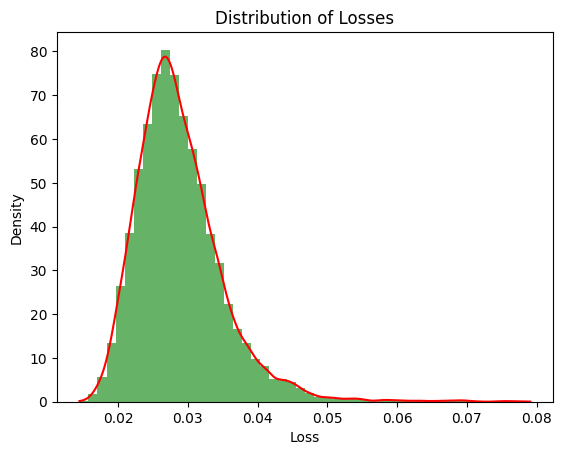

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Suponiendo que "losses" es una lista de valores de pérdida

# Creamos el histograma
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()


In [15]:
import numpy as np
THRESHOLD = np.mean(losses)
print(THRESHOLD)

0.028821080782014744


Probemos cómo el modelo se comporta para determinar que una señal de spoofing es anómala
===========================================================================================

In [17]:
anomaly_dataset,Aseq_len,An_features,Aval_dataset=dm.clean_and_get_Data('spoofing_1.csv')

el shape del dataset torch.Size([1407, 25, 3, 1])
1407 25 3
el shape del dataset torch.Size([1103, 25, 3, 1])
1103 25 3
el shape del dataset torch.Size([532, 25, 3, 1])
532 25 3


c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Source'] = df['Source'].str.replace('.', '')
c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Destination'] = df['Destination'].str.replace('.', '')


In [18]:
predictions, pred_losses = predict(loaded_model, anomaly_dataset)
#sns.distplot(pred_losses, bins=50, kde=True);

In [19]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct spoofing anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct spoofing anomaly predictions: 1407/1407


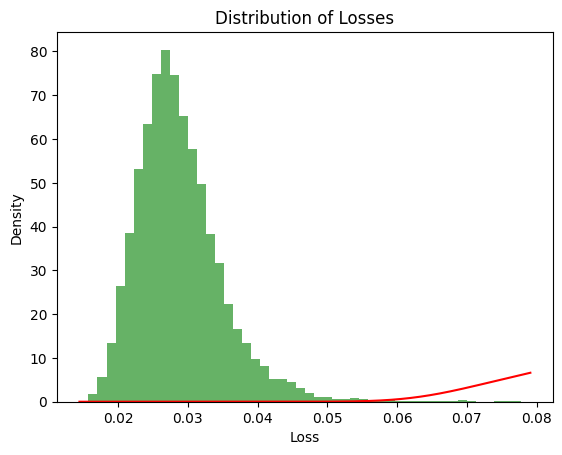

In [20]:
# Creamos el histograma
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(pred_losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()


Ahora veamos cómo detecta los DDOS
==================================

In [22]:
anomaly_dataset,Aseq_len,An_features,Aval_dataset=dm.clean_and_get_Data('ddos_short_sample.csv')

c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Source'] = df['Source'].str.replace('.', '')
c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Destination'] = df['Destination'].str.replace('.', '')


el shape del dataset torch.Size([34279, 25, 3, 1])
34279 25 3
el shape del dataset torch.Size([27014, 25, 3, 1])
27014 25 3
el shape del dataset torch.Size([13294, 25, 3, 1])
13294 25 3


In [23]:
predictions, pred_losses = predict(loaded_model, anomaly_dataset)
#sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct DDOS anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct spoofing anomaly predictions: 13682/34304


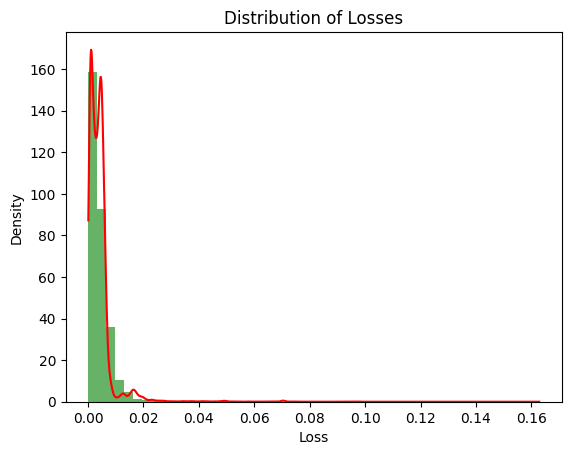

In [ ]:
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(pred_losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()

Ahora con ataques de fuerza bruta
=======================================

In [25]:
anomaly_dataset,Aseq_len,An_features,Aval_dataset=dm.clean_and_get_Data('brute_force_sample.csv')

c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Source'] = df['Source'].str.replace('.', '')
c:\Users\52333\Documents\Cybersecurity - copia\data_mining.py:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Destination'] = df['Destination'].str.replace('.', '')


el shape del dataset torch.Size([6101, 25, 3, 1])
6101 25 3
el shape del dataset torch.Size([4804, 25, 3, 1])
4804 25 3
el shape del dataset torch.Size([2354, 25, 3, 1])
2354 25 3


In [26]:
predictions, pred_losses = predict(loaded_model, anomaly_dataset)
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct  brute force attack predictions: {correct}/{len(anomaly_dataset)}')

Correct  brute force attack predictions: 6101/6101


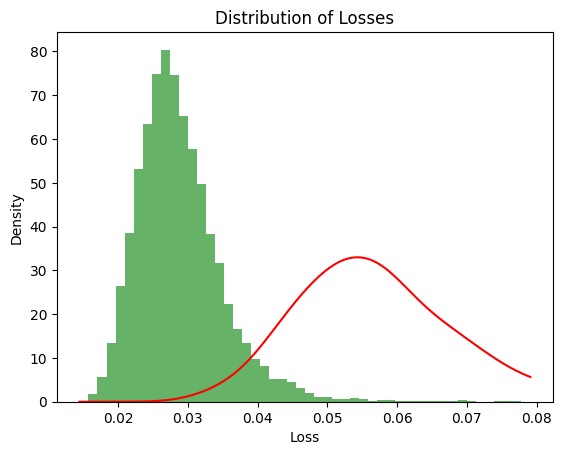

In [27]:
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(pred_losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()